In [2]:
import torch
from transformers import Owlv2Processor, Owlv2ForObjectDetection
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from PIL import Image
from io import BytesIO
import sys
from config import topview_vec, sideview_vec, tcp_X_offset, tcp_Y_offset, tcp_Z_offset
# sys.path.append("../")
from magpie_control import realsense_wrapper as real
from magpie_control.ur5 import UR5_Interface as robot
from magpie_perception.label_owlv2 import LabelOWLv2
import numpy as np
import pyrealsense2 as rs
import random
import time
import json
import warnings
import os
import cv2


2024-11-07 14:28:18.974761: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 14:28:18.974820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 14:28:19.078733: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 14:28:19.286738: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 14:28:20.675592: W tensorflow/compiler/tf2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
myrs = real.RealSense()
myrs.initConnection()
myrobot = robot()
myrobot.start()
label_vit = LabelOWLv2(topk=1, score_threshold= 0.05, cpu_override=False)
label_vit.model.eval()
#print(dir(label_vit.model))
print(label_vit.model.device)


Found Dynamixel Port:
/dev/ttyACM0

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
cuda:0


In [6]:
myrobot.open_gripper()


Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [7]:
def get_frames(rsWrapper):
    pipe, config = rsWrapper.pipe, rsWrapper.config
    frames = pipe.wait_for_frames()
    #alignOperator = rs.align(rs.stream.color)
    #alignOperator.process(frames)
    depthFrame = frames.get_depth_frame()  # pyrealsense2.depth_frame
    colorFrame = frames.get_color_frame()
    return colorFrame, depthFrame
def get_pictures(rsWrapper):
    colorFrame, depthFrame = get_frames(rsWrapper)
    #print(f"{type(starting_img)=}")
    #print(f"{dir(starting_img)=}")
    color_image = np.asarray(colorFrame.get_data())
    #color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
    depth_image = np.asarray(depthFrame.get_data())
    return color_image, depth_image

In [8]:
def pose_vector_distance(goal_vec, actual_pose):
    """
    Check if two 6-degree pose vectors are equivalent within a specified tolerance.

    Parameters:
    - goal_vec: List of target pose [x, y, z, rx, ry, rz] in meters.
    - actual_pose: List of actual pose [x, y, z, rx, ry, rz] in meters.
    - tolerance_cm: Tolerance in centimeters (default is 0.01 meters).

    Returns:
    - True if the poses are equivalent within the tolerance, False otherwise.
    """


    # Calculate linear distance
    linear_distance = np.linalg.norm(np.array(goal_vec[:3]) - np.array(actual_pose[:3]))

    # Calculate angular differences (wrap around at 2*pi)
    angular_diffs = [
        np.arctan2(np.sin(goal_vec[i] - actual_pose[i]), np.cos(goal_vec[i] - actual_pose[i]))
        for i in range(3, 6)
    ]
    angular_distance = np.linalg.norm(angular_diffs)

    # Total distance check (considering both linear and angular)
    return linear_distance, angular_distance

def goto_vec(UR_interface, goal_vec, warning_tolorance=0.01, failure_tolerance=0.1):
    #print(f"{goal_vec=}")
    goal_matrix = UR_interface.poseVectorToMatrix(goal_vec)
    UR_interface.moveL(goal_matrix, linSpeed=0.1, asynch=False)
    actual_pose = UR_interface.recv.getActualTCPPose()
    #print(f"{actual_pose=}")
    linear_error, angular_error = pose_vector_distance(goal_vec, actual_pose)
    
    success = True
    if linear_error >= warning_tolorance:
        assert linear_error < failure_tolerance, f"Linear Error greater than failure tolerance {linear_error=} {goal_vec=} {actual_pose=}"
        warnings.warn(f"Linear Error greater than warning tolerance {linear_error=} {goal_vec=} {actual_pose=}")
        success = False
    if angular_error >= warning_tolorance:
        assert angular_error < failure_tolerance, f"Angular Error greater than failure tolerance {linear_error=} {goal_vec=} {actual_pose=}"
        warnings.warn(f"Angular Error greater than warning tolerance {angular_error=} {goal_vec=} {actual_pose=}")
        success = False
    return success


In [9]:
from openai import OpenAI
import requests
import base64
import io
from APIKeys import API_KEY
from pydantic import BaseModel

client = OpenAI(
    api_key= API_KEY,
)
class object(BaseModel):
    description: str
class object_relationship(BaseModel):
    object_1: object
    object_2: object
    relationship: str
class SceneDescription(BaseModel):
    objects: list[object]
    object_relationships: list[object_relationship]
class GPT_Instruction(BaseModel):
    state: SceneDescription
    pick: str
    place: str
    Done: bool
    explanation:str
#Function that takes a list of blocks in order of the tower [red, green, blue] and produces a prompt to be given to the GPT4o in sideview
#https://platform.openai.com/docs/guides/structured-outputs/examples
def set_prompt(str_list_stack_order):
    system_prompt = ("""
                     You are a block stacking robot, your job is to take an order of colored blocks to build a tower and an image of the current state of blocks
                     Then you should output a strucutured output 
                     pick:object to be picked up,
                    place:object to place the pick object on top of,
                    Done:0/1 when the tower is complete,
                    state: which describes the state of the blocks in the image and their positions relative to eachother and the table,
                    explanation: which explains why this a good move to get to our desired tower,
                    dont forget object can be on the table, also objects do not have to be related,
                      if you want to place something on the table you must specify "empty gray table space"
                """)
    user_prompt = f"Your current task is to give me the next instruction so the blocks are stacked from bottom to top in order {str_list_stack_order} from the state in the provided image"
    return system_prompt, user_prompt

#helper function that formats the image for GPT api
def ndarray_to_base64(ndarray):
    # Convert the ndarray to a PIL Image
    image = Image.fromarray(ndarray)
    
    # Create a BytesIO object to save the image
    buffered = io.BytesIO()
    image.save(buffered, format="JPEG")  # Specify the format you want
    # Get the byte data and encode to base64
    encoded_string = base64.b64encode(buffered.getvalue()).decode('utf-8')
    
    return encoded_string

#api calling function
def get_response(system_prompt, user_prompt, img_prompt):
    image = ndarray_to_base64(img_prompt)
    img_type = "image/jpeg"
    # Save the image to a file
    response = client.beta.chat.completions.parse(
        #model="gpt-4o-mini",
        model="gpt-4o",
        
        messages=[
            #{ "role": "system", "content": [{"type": "text", "text": str_prompt},{"type": "image_url", "image_url": {"url": f"data:{img_type};base64,{image}"},},],},
            #{"role": "user", "content": user_prompt}

            #changed some stuff here commented original version -max
            { "role": "system", "content": system_prompt},  # Only text in the system message
        
            # The user message contains the text prompt and the image URL
            { 
                "role": "user", 
                "content": user_prompt,
                "attachments": [
                    {"type": "image_url", "image_url": f"data:{img_type};base64,{image}"}
                ]
            }
        ],
        response_format=GPT_Instruction
    ) 
    return response, response.choices[0].message.parsed




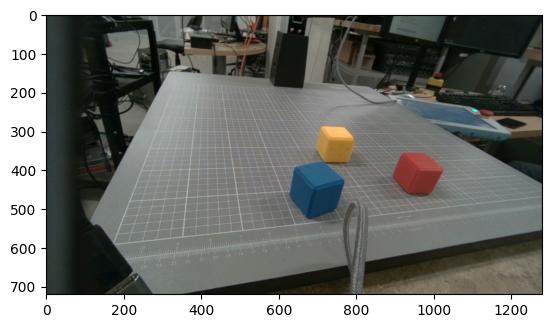

sys_prompt='\n                     You are a block stacking robot, your job is to take an order of colored blocks to build a tower and an image of the current state of blocks\n                     Then you should output a strucutured output \n                     pick:object to be picked up,\n                    place:object to place the pick object on top of,\n                    Done:0/1 when the tower is complete,\n                    state: which describes the state of the blocks in the image and their positions relative to eachother and the table,\n                    explanation: which explains why this a good move to get to our desired tower,\n                    dont forget object can be on the table, also objects do not have to be related,\n                      if you want to place something on the table you must specify "empty gray table space"\n                '
usr_prompt="Your current task is to give me the next instruction so the blocks are stacked from bottom to top in 

'\ngptresp, instruction = get_response(sys_prompt, usr_prompt, rgb_img)\nprint(gptresp)\nprint(instruction)\nprint(type(instruction))\nprint(dir(instruction))\nprint(instruction.pick)\nprint(instruction.place)\nprint(instruction.Done)\n\n'

In [ ]:
goto_vec(myrobot, sideview_vec)
rgb_img, depth_img = get_pictures(myrs)
plt.figure()
plt.imshow(rgb_img)
plt.show()
plt.imsave("side_view_0.png", rgb_img)

##--string for GPT QUERY--##
sys_prompt, usr_prompt = set_prompt(["red block", "blue block", "green block"])
print(f"{sys_prompt=}")
print(f"{usr_prompt=}")

##--GPT QUERY--##
"""
gptresp, instruction = get_response(sys_prompt, usr_prompt, rgb_img)
print(gptresp)
print(instruction)
print(type(instruction))
print(dir(instruction))
print(instruction.pick)
print(instruction.place)
print(instruction.Done)

"""


In [8]:
def parse_gpt(response):
    content = response[3]
    

In [9]:
def get_depth_frame_intrinsics(rs_wrapper):
    rgb_frame, depth_frame = get_frames(rs_wrapper)
    intrinsics = depth_frame.profile.as_video_stream_profile().intrinsics
    return depth_frame, intrinsics

def get_topview_depth(point_list, UR_interface, rs_wrapper, n_samples = 50):
    goto_vec(UR_interface, topview_vec)
    depth_measurements = [[] for p in point_list]
    intrinsics = None
    for i in range(n_samples):
        depth_frame, intrinsics = get_depth_frame_intrinsics(rs_wrapper)
        for i, (x, y) in enumerate(point_list):
            depth_val = depth_frame.get_distance(x, y)  # in meters
            if depth_val > 0:
                depth_measurements[i].append(depth_val)

    
    depth_measurements = [np.array(point_measurements) for point_measurements in depth_measurements]
    final_depth_measurements = [0 for point in point_list]
    for i, measurements in enumerate(depth_measurements):
        std = np.std(measurements)
        mean = np.mean(measurements)
        in_std_mask = np.abs(measurements-mean) <= std
        depth_measurements = measurements[in_std_mask]
        #print(f"{depth_measurements=}")
        depth_val = sum(measurements)/len(measurements)
        #print(f"{depth_val=}")
        assert depth_val > 0, f"not able to get depth val after {n_samples} samples {depth_val=}"
        final_depth_measurements[i] = depth_val
    return final_depth_measurements

def deproject_top_view_point(K, pixel_x, pixel_y, depth):
    return rs.rs2_deproject_pixel_to_point(K, [pixel_x, pixel_y], depth)

In [10]:
"""

pick_place_BB takes the color of the block that needs to be picked up and the color of the block 
to be placed on and gives the cords of where each are located as {xmin, ymin, xmax, ymax, strlabel}

"""
def topview_pick_place_BB(UR_Interface, rs_wrapper, pick_str, place_str, display= False):
    #print(place_str)
    #initlize local variables
    goto_vec(UR_Interface, topview_vec)
    rgb_img, depth_img = get_pictures(rs_wrapper)
    pick_cord_dict, place_cord_dict = {} , {}
    str_cords = ["xmin", "ymin", "xmax", "ymax"]
    queries = [pick_str, place_str]
    abbrevq = [pick_str, place_str]
    
    #pick bboxes and cords
    with torch.no_grad():
        pick_bbox = label_vit.label(rgb_img, queries[0], abbrevq[0], plot=False, topk=True)
        place_bbox = label_vit.label(rgb_img, queries[1], abbrevq[1], plot=False, topk=True)

    pick_bbox_cords = pick_bbox[1][0].tolist()
    for pick , cord in zip(pick_bbox_cords, str_cords):
        pick_cord_dict[cord] = int(pick)
    pick_cord_dict["strlabel"] = pick_str
    pick_cord_dict["xCenter"] = int((pick_cord_dict['xmin'] + pick_cord_dict["xmax"])/2)
    pick_cord_dict["yCenter"] = int((pick_cord_dict['ymin'] + pick_cord_dict["ymax"])/2)
    
    

    #place bboxes and cords
    place_bbox_cords = place_bbox[1][0].tolist()
    for pick , cord in zip(place_bbox_cords, str_cords):
        place_cord_dict[cord] = int(pick)
    place_cord_dict["strlabel"] = place_str
    place_cord_dict["xCenter"] = int((place_cord_dict['xmin'] + place_cord_dict["xmax"])/2)
    place_cord_dict["yCenter"] = int((place_cord_dict['ymin'] + place_cord_dict["ymax"])/2)

    if display:
        fig, ax = plt.subplots(1)
        ax.imshow(rgb_img)
        pick_rect = patches.Rectangle(
                                    (pick_cord_dict["xmin"], pick_cord_dict["ymin"]),
                                      pick_cord_dict["xmax"] - pick_cord_dict["xmin"],
                                      pick_cord_dict["ymax"] - pick_cord_dict["ymin"],
                                      linewidth=2, edgecolor='r', facecolor='none'
                                      )
        ax.add_patch(pick_rect)
        ax.text(pick_cord_dict["xmin"], pick_cord_dict["ymin"] - 10, f"pick: {pick_cord_dict['strlabel']}", color='r', fontsize=12, ha='left', va='bottom')
        

        place_rect = patches.Rectangle(
                                    (place_cord_dict["xmin"], place_cord_dict["ymin"]),
                                      place_cord_dict["xmax"] - place_cord_dict["xmin"],
                                      place_cord_dict["ymax"] - place_cord_dict["ymin"],
                                      linewidth=2, edgecolor='g', facecolor='none'
                                      )
        ax.add_patch(place_rect)
        ax.text(place_cord_dict["xmin"], place_cord_dict["ymin"] - 10, f"place {place_cord_dict['strlabel']}", color='g', fontsize=12, ha='left', va='bottom')
        ax.set_title("pick and place bb in rgb", fontsize=14)

        plt.show()

    _, K = get_depth_frame_intrinsics(rs_wrapper)
    depth_querry_list = [
        (pick_cord_dict["xCenter"], pick_cord_dict["yCenter"]),
        (pick_cord_dict['xmin'], pick_cord_dict['ymin']),
        (pick_cord_dict['xmax'], pick_cord_dict['ymin']),
        (place_cord_dict["xCenter"], place_cord_dict["yCenter"]),
        (place_cord_dict['xmin'], place_cord_dict['ymin']),
        (place_cord_dict['xmax'], place_cord_dict['ymin'])
    ]
    pick_c_d, pick_ll_d, pick_lr_d, place_c_d, place_ll_d, place_lr_d = get_topview_depth(depth_querry_list, UR_Interface, rs_wrapper)

    pick_cord_dict["ImgFrameWorldCoord"] = deproject_top_view_point(K, pick_cord_dict["xCenter"], pick_cord_dict["yCenter"], pick_c_d)
    pick_LL_X, pick_LL_Y, pick_LL_Z = deproject_top_view_point(K, pick_cord_dict['xmin'], pick_cord_dict['ymin'], pick_ll_d)
    pick_LR_X, pick_LR_Y, pick_LR_Z = deproject_top_view_point(K, pick_cord_dict['xmax'], pick_cord_dict['ymin'], pick_lr_d)
    pick_sidelength =  (pick_LL_X-pick_LR_X)**2
    pick_sidelength += (pick_LL_Y-pick_LR_Y)**2
    pick_sidelength += (pick_LL_Z-pick_LR_Z)**2
    pick_sidelength = np.sqrt(pick_sidelength)
    pick_cord_dict["sidelength"] = pick_sidelength
    print(f"{pick_cord_dict=}")

    place_cord_dict["ImgFrameWorldCoord"] = deproject_top_view_point(K, place_cord_dict["xCenter"], place_cord_dict["yCenter"], place_c_d)
    place_LL_X, place_LL_Y, place_LL_Z = deproject_top_view_point(K, place_cord_dict['xmin'], place_cord_dict['ymin'], place_ll_d)
    place_LR_X, place_LR_Y, place_LR_Z = deproject_top_view_point(K, place_cord_dict['xmax'], place_cord_dict['ymin'], place_lr_d)
    place_sidelength =  (place_LL_X-place_LR_X)**2
    place_sidelength += (place_LL_Y-place_LR_Y)**2
    place_sidelength += (place_LL_Z-place_LR_Z)**2
    place_sidelength = np.sqrt(place_sidelength)
    place_cord_dict["sidelength"] = place_sidelength
    print(f"{place_cord_dict}=")
    

    
    


    #return dictionarys with {xmin, ymin, xmax, ymax, strlabel}
    #return (pick_bbox, pick_cord_dict) , (place_bbox, place_cord_dict)
    return pick_cord_dict, place_cord_dict

   



In [11]:
def pick(UR_interface, bb):
    X, Y, Z = bb["ImgFrameWorldCoord"]
    print(f"Camera Frame Coordinates of Block: {X=}, {Y=}, {Z=}\n")
    new_X = topview_vec[0] - Y + tcp_X_offset
    new_Y = topview_vec[1] - X + tcp_Y_offset
    new_Z = topview_vec[2] - Z + tcp_Z_offset
    
    success = True
    goal_vec = topview_vec.copy()
    goal_vec[0] = new_X
    goal_vec[1] = new_Y
    success = goto_vec(UR_interface, goal_vec)

    goal_vec[2] = new_Z
    success = goto_vec(UR_interface, goal_vec)

    UR_interface.close_gripper()
    time.sleep(2)

    goal_vec[2] = topview_vec[2]
    success = goto_vec(UR_interface, goal_vec)
    return success

#pick(myrobot, myrs, pick_bb, display = True)

In [12]:
def place(UR_interface, bb):
    X, Y, Z = bb["ImgFrameWorldCoord"]
    print(f"Camera Frame Coordinates of Block: {X=}, {Y=}, {Z=}\n")
    new_X = topview_vec[0] - Y + tcp_X_offset
    new_Y = topview_vec[1] - X + tcp_Y_offset
    new_Z = topview_vec[2] - Z + bb["sidelength"] + tcp_Z_offset

    success = True
    goal_vec = topview_vec.copy()
    goal_vec[0] = new_X
    goal_vec[1] = new_Y
    success = goto_vec(UR_interface, goal_vec)

    goal_vec[2] = new_Z
    success = goto_vec(UR_interface, goal_vec)


    UR_interface.open_gripper()
    time.sleep(2)

    goal_vec[2] = topview_vec[2]
    success = goto_vec(UR_interface, goal_vec)

    return success
#place(myrobot, myrs, place_bb, display = True)

No LLM PLANNING

In [13]:
#myrobot.stop()
#myrs.disconnect()
#tower = ["red block", "blue block", "green block", "yellow block", "purple block", "orange block"]
"""
tower = ["yellow block", "blue block", "red block"]#, "green block"]
for i in range(0, len(tower)-1):
     pick_str = tower[i+1]
     place_str = tower[i]
     pick_bb, place_bb = topview_pick_place_BB(myrobot, myrs, pick_str, place_str, display=True)
     pick(myrobot, pick_bb)
     place(myrobot, place_bb)


"""

'\ntower = ["yellow block", "blue block", "red block"]#, "green block"]\nfor i in range(0, len(tower)-1):\n     pick_str = tower[i+1]\n     place_str = tower[i]\n     pick_bb, place_bb = topview_pick_place_BB(myrobot, myrs, pick_str, place_str, display=True)\n     pick(myrobot, pick_bb)\n     place(myrobot, place_bb)\n\n\n'

YES LLM PLANNING

In [1]:
#tower = ["red block", "blue block", "green block", "yellow block", "purple block"]
tower = ["red block", "blue block", "yellow block"]
n_attempts = 2*len(tower)
Done = 0
i = 0

while(not Done and i < n_attempts):
    i += 1
    goto_vec(myrobot, sideview_vec)
    rgb_img, depth_img = get_pictures(myrs)
    plt.imshow(rgb_img)
    plt.title(f"side view {i}")
    plt.show()
    plt.imsave("sideview_0.png",rgb_img)
    sys_str, usr_str = set_prompt(tower)
    gptresp, instruction = get_response(sys_str, usr_str, rgb_img)
    Done = int(instruction.Done)#["Done"])
    
    print()
    print(f"{instruction.state.objects=}")
    print(f"{instruction.state.object_relationships=}")
    print(f"{instruction.pick=}")
    print(f"{instruction.place=}")
    print(f"{instruction.Done=}")
    print(f"{instruction.explanation=}")

    print()
    if Done:
        break
    pick_str= instruction.pick#["pick"]
    place_str= instruction.place#["place"]
    pick_bb, place_bb = topview_pick_place_BB(myrobot, myrs, pick_str, place_str, display=True)
    pick(myrobot, pick_bb)
    place(myrobot, place_bb)


NameError: name 'goto_vec' is not defined